# Fake News Machine learning prediction model

## Imports

In [2]:
# Generic
import pandas as pd
import re
import os
import numpy as np
#from tqdm import tqdm
from tqdm import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# Natural Language Processing
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# Machine learning modelling Helpers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Modelling Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

# Random
import itertools

# Visualizations
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Creating a function that outputs a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Loading and filtering data

In [4]:
# First we load the data
train = pd.read_csv('./fake-news/train.csv')
# Then we check for any missing values in the data
print("Empty Training data:")
print(train.isnull().sum())

Empty Training data:
id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [5]:
#Seeing as there is some empty data, we have to fill this with something
# We are working with text so we'll fill it with empty strings:
train = train.fillna("")

In [6]:
# Inspecting the data
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
# To make an accurate predection we want to include all the relevant factors when passing data to the model
# In our case, both the title, the author and the content can be an indication of fake news
train['content']=train['author'] +': ' + train['title'] + '\n' + train['text']

**Stemming** <br>
To determine which words are important in the fake news articles, we have to "Stem" them.
In other words reduce them to their roots to unify them.
Example:
* waited,waiting,waits -> wait

To do this we use the python package **N**atural **L**anguage **T**ool**k**it (nltk)

In [8]:
# Create pickle of df to be able to use cached value
useCachedStem = True
picklePath = './stemmedData.pkl'
# First we utilize a port stemmer to stem the words from the article content
port_stem = PorterStemmer()
# Next we specify a function that both applies this port stemmer algorithm and cleans the content 
def stemContent(content):
    content = re.sub('[^a-zA-Z]',' ',content) # Remove \#!€ etc.
    content = content.lower() # Change all to lowercase
    content = content.split() # Convert into an array to apply port stemmer algorithm on each word
    # Stem each word if it is not a stop word (words commenly used in a language but don't provide 
    # any value for the machine learning categorization task (for, an, nor, but, or, yet, so etc.))
    # This allows for faster processing later on
    content = [port_stem.stem(word) for word in content if not word in stopwords.words('english')] 
    content = ' '.join(content) # Join the list of stemmed words back into one string
    return content

if not useCachedStem:
    # Apply the stemming function to each element in the dataset:
    train['content'] = train['content'].progress_apply(stemContent)
    print(train['content'])
    train.to_pickle(picklePath)
else:
    if os.path.exists(picklePath):
        train = pd.read_pickle(picklePath)
    else:
        raise Exception("Error no cached pickle file. Run the function with useCachedStem=False to recalcuate the df, and create the pickle file '" + os.path.basename(picklePath) + "'" )

    

In [9]:
# We devidie the data into text (X) and label (Y) as well as training (80%) and test data (20%)
# NOTE: random_state is set to get the same division of the data each time the code is run
X_train, X_test, y_train, y_test = train_test_split(train['content'], train['label'], test_size=0.20, random_state=0) 

# Feature extraction / encoding
Machine learning algorithms cannot work with raw text directly. The text must therefore be converted into numbers. Specifically, vectors of numbers. This process is call feature encoding or feature extraction

## Vectorization
Next we have to **Vectorize** our text, i.e. convert each word to a number. <br>
### Count vectorization
To calcualte the word frequency scores we first have to instantiate a <em><strong>Count Vectorizer</strong></em>. <br>
The sklearn `CountVectorizer` is used to convert a collection of text documents into a vector of term/token counts. <br>
In other words it creates a matrix that indicates which words a document contains as seen below:
<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--qveZ_g7d--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://raw.githubusercontent.com/cassieview/intro-nlp-wine-reviews/master/imgs/vectorchart.PNG"/>


In [10]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
# Fit and transform the training data.
# In other words calculate counts with a given corpus (iterable of documents)
count_train = count_vectorizer.fit_transform(X_train)

# Next we transform the test set 
# Simply put we map the vocabulary from the training data to that of the test data, so that the number of feautres in the test data remains the same as in the training data
count_test = count_vectorizer.transform(X_test)

## Multinomial Naive Bayes with Count Vectorizer (BagofWords)
Now that we have our Count Vectorizer we can start to produce actual machine learning models to use on the data. <br>
The first one of these will be the classic <em><strong>bag-of-words</strong></em> model. <br>
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

1. A vocabulary of known words.
2. A measure of the presence of known words.

It is called a “bag” of words, seeing as any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.<br>
This is basicaly what our Counter Vectorizer is. A vector with counts of how many times various words appear in a document. 
In combination with this we will be utilizing the classic <em><strong>Multinomial Naive Bayes</strong></em> machine learning model. <br>
The Multinomial Naive Bayes algorithm is a probabilistic learning method in which the probability of each tag for a given sample is calculated and the tag with the highest probability is chosen as output.<br>
Bayes theorem, formulated by Thomas Bayes, calculates the probability of an event occurring based on the prior knowledge of conditions related to an event. The theorem is based on the following formula:

P(A|B) = P(A) * P(B|A)/P(B)

Where we are calculating the probability of class A when predictor B is already provided.

P(B) = prior probability of B

P(A) = prior probability of class A

P(B|A) = occurrence of predictor B given class A probability

To do this in python we utilize the <em>MultinomialNB</em> classifier that the sklearn library provides. <br>
We then perform the same step as with the vectorizers: we fit the model to the data. After this we can use the model to make a prediction on the test data and finally get it to output the average accuracy it achieved with the metrics.accuracy_score, also provided by the sklearn library


In [11]:
# Create the Multinomial naive bayes classifier
nb_classifier = MultinomialNB(alpha = 0.1)
# Fit it to the data
nb_classifier.fit(count_train, y_train)
# Attempt to predict on the test data
pred_nb_count = nb_classifier.predict(count_test)
# Extract the accurary and print it
acc_nb_count = metrics.accuracy_score(y_test, pred_nb_count)
print("Accuracy: {}%".format(acc_nb_count*100))

Accuracy: 92.95673076923077%


### Fiddling with the alpha value
As seen we achieve a fairly high accuracy. Though how can we make it better with this model? <br>
The avid coder will have noticed that an <em>alpha</em> value is passed into the Multinomial naive bayes classifier. This is a <em><strong>hyperparameter</strong></em>. In other words a parameter that controls the form of the model itself. In this case it is a laplace smoothing parameter which with a higher value diverges toward a uniform distribution (of words). This parameter is in place so that if we encounter a word in the test set, which is not in the training set, we don't just get a probability of zero for that word (to indicate fake-news). Instead the alpha parameter increases all probabilities, so that we hence avoid having proabilities of 0.

Let's try to play with this parameter and see what value supplies the most optimal accuracy


In [12]:
# Perform same steps as previous cell but change alpha each time
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train, y_train)
    pred_tune = nb_classifier_tune.predict(count_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}%".format(alpha, score*100))

/opt/homebrew/Caskroom/miniconda/base/envs/ML-env/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.00 Score: 89.20673%
Alpha: 0.05 Score: 92.83654%
Alpha: 0.10 Score: 92.95673%
Alpha: 0.15 Score: 92.93269%
Alpha: 0.20 Score: 93.00481%
Alpha: 0.25 Score: 92.93269%
Alpha: 0.30 Score: 92.95673%
Alpha: 0.35 Score: 92.90865%
Alpha: 0.40 Score: 92.86058%
Alpha: 0.45 Score: 92.74038%
Alpha: 0.50 Score: 92.66827%
Alpha: 0.55 Score: 92.62019%
Alpha: 0.60 Score: 92.40385%
Alpha: 0.65 Score: 92.37981%
Alpha: 0.70 Score: 92.25962%
Alpha: 0.75 Score: 92.25962%
Alpha: 0.80 Score: 92.18750%
Alpha: 0.85 Score: 92.09135%
Alpha: 0.90 Score: 91.87500%
Alpha: 0.95 Score: 91.68269%


As seen the best score obtained is 93.00% with an alpha of 0.20. Lets look at the confusion matrix with this value of alpha

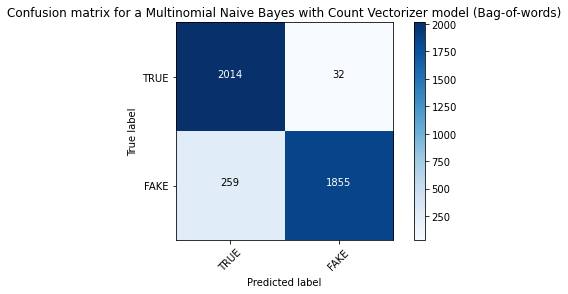

In [13]:
# Create the Multinomial naive bayes classifier
nb_classifier = MultinomialNB(alpha = 0.20)
# Fit it to the data
nb_classifier.fit(count_train, y_train)
# Attempt to predict on the test data
pred_nb_count = nb_classifier.predict(count_test)
# Create confusion matrix and plot it:
cm = metrics.confusion_matrix(y_test, pred_nb_count, labels=[0,1])
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Confusion matrix for a Multinomial Naive Bayes with Count Vectorizer model (Bag-of-words)')

As seen we do get quite a lot of false positives which isn't great.
## Increasing the performance of Multinomial naive bayes
To figure out which words, or sequence of words, give an indication of fake-news we will have to look at <em><strong>word frequencies</strong></em> one way or another. To avoid the impact of words or <em><strong>tokens</strong></em> that occur frequently in a given <em><strong>corpus</strong></em> (set of documents) we use a **T**erm **F**requency **I**nverse **D**ocument **F**requency or TF-IDF for short. This is an algorithm that transforms text into a meaningful representation of numbers that our future machine learning algorithm(s) can use for prediction. By using a TFIDF the impact of frequently occuring tokens, which are hence emperically less informative, is reduced compared to features/tokens that occur in a small fraction of the training corpus. <br>
TF-IDF is simply put a measure of how <em>original</em> a word is. It compares the number of times a word appears in a document with the number of of documents the word appers in.<br>
More Formally:<br>
<p align="center">
<img src="https://latex.codecogs.com/svg.image?TF-IDF&space;=&space;TF(t,d)*IDF(t)"/><br>
</p>
Whereof:
<ul>
<li>d = a document</li>
<li>t = Term Frequency / number of times term t appears in a doc, d</li>
<li>IDF = Inverse document frequency</li>
</ul>
Where IDF is defined as:<br>
<p align="center">
<img src="https://latex.codecogs.com/svg.image?IDF(t)&space;=&space;log(\frac{1&plus;n}{1&plus;df(d,t)}&plus;1)" /><br>
</p>
Whereof:
<ul>
<li>n = # of documents</li>
<li>df(d,t) = document frequency of the term t / how many documents the term t appears in</li>
</ul>

To do this in Python we utilize the `TfidfVectorizer` provided by the sklearn library. 

When instantiating the `TfidVectorizer` from sklearn we pass in a list of stop words (i.e. words that don't add any meaning or value to what a given piece of text is about) as well as defining what dimension of <em>**n-grams**</em> we want. Just as we did with the `CountVectorizer`<br>
An <em>**n-gram**</em> is simply a sequence of <em>**N**</em> words. This is often use in NLP applications like autocompletion of sentences. After being trained on a huge <em>**Corpus**</em> of data the model will be able to predict what word has the highest probability of following a sequence of words. <br>
If you for example wrote "Thank you so much for your" most humans would easily deduce that the next word in that sentence would be <em>"time"</em> or <em>"help"</em>. For a machine to do this you tell it to gather words in <em>**n-grams**</em>, as for example:
<ul>
<li>San Francisco (is a 2-gram)</li>
<li>The Three Musketeers (is a 3-gram)</li>
<li>She stood up slowly (is a 4-gram)</li>
</ul>

This is used in our `TfidfVectorizer` to capture the <em><strong>context</strong></em> in which word are used together.
In other words the vectorizer doesn't simply just look at single words and produce a matrix with numbers for each word but produces a matrix with sequences of words in context and gives each of these a number for identification.<br>
In our case we will start by trying to look for <em><strong>bigrams</strong></em>
The TfIDF vectorizer basically first creates a `CountVectorizer` <strong>and</strong> calculates the Inverse Document Frequency (IDF) and finally with these compute the TF-IDF scores.


In [14]:
# Initialize the TFIDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2),use_idf=True)

## Fit and transform the training data 
# We make the model learn vocabulary and IDF from training set (fit the model to the training data and save the vectorizer/model as a variable) 
# Put simply the fit method calculates the mean and variance of each of the features present in the dataset.

tfidf_train = tfidf_vectorizer.fit_transform(X_train)

## Transform the test set 
# Furthemore we also transform the traning data (to look for bigrams and exclude stopwords as defined above)
# Again this simply means that we map the vocabulary from the training data to that of the test data, 
# so that the number of feautres in the test data remains the same as in the training data

tfidf_test = tfidf_vectorizer.transform(X_test)


In [15]:
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(tfidf_train, y_train)
    pred_tune = nb_classifier_tune.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}%".format(alpha, score*100))

/opt/homebrew/Caskroom/miniconda/base/envs/ML-env/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.00 Score: 88.48558%
Alpha: 0.05 Score: 93.14904%
Alpha: 0.10 Score: 92.18750%
Alpha: 0.15 Score: 91.27404%
Alpha: 0.20 Score: 90.67308%
Alpha: 0.25 Score: 89.97596%
Alpha: 0.30 Score: 89.35096%
Alpha: 0.35 Score: 88.67788%
Alpha: 0.40 Score: 88.36538%
Alpha: 0.45 Score: 87.90865%
Alpha: 0.50 Score: 87.45192%
Alpha: 0.55 Score: 87.01923%
Alpha: 0.60 Score: 86.46635%
Alpha: 0.65 Score: 86.15385%
Alpha: 0.70 Score: 85.96154%
Alpha: 0.75 Score: 85.67308%
Alpha: 0.80 Score: 85.40865%
Alpha: 0.85 Score: 85.14423%
Alpha: 0.90 Score: 85.00000%
Alpha: 0.95 Score: 84.73558%


As seen we obtain a slightly higher score than with simply the count vectorizer with an alpha of 0.05 resulting in an accuracy of 93.15%. Plotting the confusion matrix for this gives us:

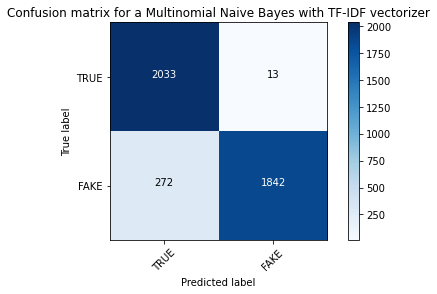

In [16]:
# Create the Multinomial naive bayes classifier
nb_classifier = MultinomialNB(alpha = 0.05)
# Fit it to the data
nb_classifier.fit(tfidf_train, y_train)
# Attempt to predict on the test data
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
# Create confusion matrix and plot it:
cm2 = metrics.confusion_matrix(y_test, pred_nb_tfidf, labels=[0,1])
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'], title ='Confusion matrix for a Multinomial Naive Bayes with TF-IDF vectorizer')

As seen we do get slightly more correctly labelled as actual fake-news but at the same time we get more fake positives. 
We will have to use something else than naive bayes to achieve a good score.
## Passive Aggresive Classifier with a Count Vectorizer
Passive aggressive classifiers are a form of machine learning algorithms that work slightly different than the more conventional algorithms in the sence that it is an <em><strong>online-learning algorithm</strong></em>. <br>
In other words the input data comes sequentially and the machine learning model is updated setp-by-step as oppposed to <em><strong>batch</strong></em> learning in which the entire training dataset is used at once. <br>
<em><strong>Online-learning algorithms</strong></em> are quite useful in situations where there is such a vast amount of data, that it becomes unfeasable to train on the entire dataset. Such as when you have a dataset of fake-news stories which are constantly being posted anew online.

### How Passive aggressive algorithms work
The passive aggressive algorithms have as the name implies two important properties:
* <strong>Passiveness</strong>: if the prediction made is correct, keep the model and don't make any changes.
* <strong>Aggressiveness</strong>: If the prediction is incorrect, make changes to the model.

The `PassiveAgressiveClassifier` provided by the sklearn package takes 3 input parameters when instantiating a model:

* <strong>C</strong> : This is the regularization parameter, and denotes the penalization the model will make on an incorrect prediction
* <strong>max_iter</strong> : The maximum number of iterations the model makes over the training data.
* <strong>tol</strong> : The stopping criterion. If it is set to None, the model will stop when (loss > previous_loss  –  tol). By default, it is set to 1e-3.

We now combine this classifier with the `CountVectorizer`and `TfidfVectorizer` respectively to see if this will improve the accuracy of the model

Accuracy: 95.67308%


/opt/homebrew/Caskroom/miniconda/base/envs/ML-env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


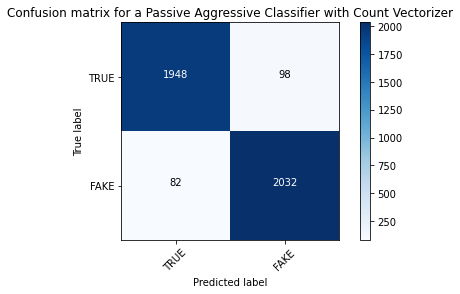

In [17]:
# Instantiate the model
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
# Fit the model to the ((count) vectorized) training data
linear_classifier.fit(count_train, y_train)
# Make a prediction
pred_linear_count = linear_classifier.predict(count_test)
# Extract the accuracy and print it
acc_linear_count = metrics.accuracy_score(y_test, pred_linear_count)
print("Accuracy: {:.5f}%".format(acc_linear_count*100))
# Create a confusion matrix and plot it
cm3 = metrics.confusion_matrix(y_test, pred_linear_count, labels=[0,1])
plot_confusion_matrix(cm3, classes=['TRUE','FAKE'], title ='Confusion matrix for a Passive Aggressive Classifier with Count Vectorizer')

Accuracy: 97.64423%


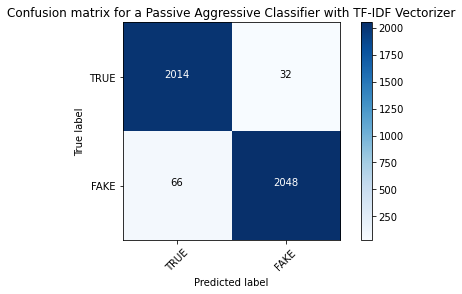

In [18]:
# Instantiate the model
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
# Fit the model to the (TF-IDF) training data
linear_classifier.fit(tfidf_train, y_train)
# Make a prediction
pred_linear_tfidf = linear_classifier.predict(tfidf_test)
# Extract the accuracy and print it
acc_linear_tfidf = metrics.accuracy_score(y_test, pred_linear_tfidf)
print("Accuracy: {:.5f}%".format(acc_linear_tfidf*100))
# Create a confusion matrix and plot it
cm4 = metrics.confusion_matrix(y_test, pred_linear_tfidf, labels=[0,1])
plot_confusion_matrix(cm4, classes=['TRUE','FAKE'], title ='Confusion matrix for a Passive Aggressive Classifier with TF-IDF Vectorizer')

As seen this grants a vastly higher performance than with the bag-of-words method with the `CountVectorizer`comming in at 95.79% and the `TfidfVectorizer`comming in at 97.86%.

Looking at each of their respective confusion matrixes we also see that the `CountVectorizer` produced a few more fake positives than the `TfidfVectorizer` while also producing less true positives as well as true negatives. Finally the `CountVectorizer` produced nearly 4 times as many false negatives.

All in all the `PassiveAggressiveClassifier` used in conjunction with the `TfidfVectorizer` produced the overall best performance thus far.

## Logistic Regression
Logistic regression is a method used in statistics for modeling the probability of a discrete outcome given an input variable. In this case a binary outcome: fake-news or not fake-news. You can also have multinomial logistic regression (i.e. is a car blue, red, orange etc.) or ordinal (three or more categories with ranking (e.g. 1-5 stars)).
Once again the sklearn library provides us with what we need with its `LogisticRegression`class.
This takes as input the <em>inverse of regularization strength</em> denoted C. <br>
<em><strong>Regularization</strong></em> means to apply a penalty for increasing the magnitude of parameter values in order to reduce overfitting.
When a model is trained, the parameters that best fit the data are chosen for that model. This can result in the model being <em><strong>overfitted</strong></em> to that specific dataset. This often happens when you have a small dataset. Simply put you balance out the <em>small pertubances</em> that occur in the data so that you avoid overfitting.<br>
In this case having a high value of C tells the model to give high weight to the training data and lower the weight of penalizing complexity (the pertubances in the data). In other words allowing for more overfitting while a lower value of C would induce an opposite effect. <br>
Once again we'll try with both the `CountVectorizer` and the `TfidfVectorizer`
### Logistic Regression with `CountVectorizer`

Accuracy: 97.25962%


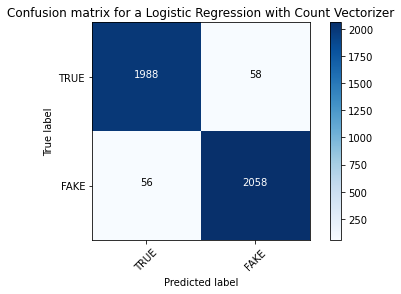

In [23]:
# Instantiate the model
logreg = LogisticRegression(C=1e6)
# Fit the model to the (TF-IDF) training data
logreg.fit(count_train, y_train)
# Make a prediction
pred_logreg_count = logreg.predict(count_test)
# Extract the accuracy and print it
acc_logreg_count = metrics.accuracy_score(y_test,pred_logreg_count)
print("Accuracy: {:.5f}%".format(acc_logreg_count*100))
# Create a confusion matrix and plot it
cm5 = metrics.confusion_matrix(y_test, pred_logreg_count, labels=[0,1])
plot_confusion_matrix(cm5, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Count Vectorizer')

### Logistic Regression with `TfidfVectorizer`

Accuracy: 97.64423%


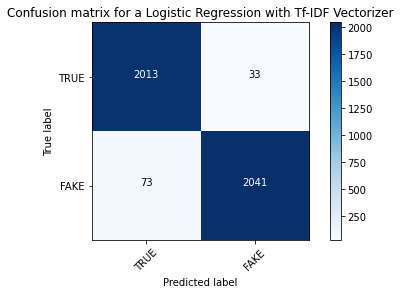

In [24]:
# Instantiate the model
logreg = LogisticRegression(C=1e6,max_iter=10000)
# Fit the model to the (TF-IDF) training data
logreg.fit(tfidf_train, y_train)
# Make a prediction
pred_logreg_tfidf = logreg.predict(tfidf_test)
# Extract the accuracy and print it
acc_logreg_tfidf = metrics.accuracy_score(y_test,pred_logreg_tfidf)
print("Accuracy: {:.5f}%".format(acc_linear_tfidf*100))
# Create a confusion matrix and plot it
cm6 = metrics.confusion_matrix(y_test, pred_logreg_tfidf, labels=[0,1])
plot_confusion_matrix(cm6, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Tf-IDF Vectorizer')